In [ ]:
#Alejandra Ocampo, Valentina Malagon, Carlos Bohorquez 
# Librerías
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
import pylab as py
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import binom
from scipy import stats
import inspect
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import warnings
import cvxpy as cp
warnings.simplefilter("ignore")
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 934 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# Punto 1: Accion de preferencia-Enero 2016/Diciembre 2021

In [ ]:
# Precios históricos para la accion seleccionada, mu y sigma 
activos = ["CROX"]
precios = yf.download(activos,start="2016-01-01",end="2021-12-31")
precios = precios.loc[:,"Adj Close"]
retornos=np.log(precios/precios.shift()).dropna()
mu=retornos.mean()
sigma=retornos.std()
mu,sigma

[*********************100%***********************]  1 of 1 completed


(0.0017047940860971153, 0.03549098072726495)

In [ ]:
datos0=pd.DataFrame(precios)

In [ ]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    St = S # {"S":S} 
    return St

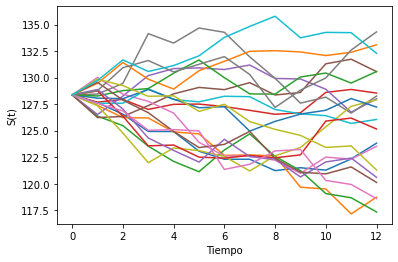

In [ ]:
T = 1
mu = mu
sigma = sigma
S0 = datos0.iloc[-1,:]
NS = 10000
M = 12
St0 = PathsGBM(S0,mu,sigma,T,NS,M)
b=St0[0:20,:]
plt.plot(np.transpose(b)) 
plt.xlabel("Tiempo")
plt.ylabel("S(t)");

El valor inicial del recorrido aleatorio corresponde al último valor obtenido para la empresa Crocs, en Diciembre de 2021. De ahí, se crearon 10.000 recorridos, de los cuales se muestran los primeros 20, en un  periodo de un año. Un recorrido individual presenta 12 datos, correspondientes a los meses del año que se presenta.

In [ ]:
datosretorno=pd.DataFrame(retornos)

In [ ]:
T = 1
mu = mu
sigma = sigma
S03 = datosretorno.iloc[-1,:]
NS = 10000
M = 12
St3 = PathsGBM(S03,mu,sigma,T,NS,M)
St3

array([[-0.01223306, -0.01217916, -0.01216102, ..., -0.01186584,
        -0.01187828, -0.01184736],
       [-0.01223306, -0.01224293, -0.01234906, ..., -0.01233924,
        -0.0123935 , -0.01239265],
       [-0.01223306, -0.01222221, -0.01248267, ..., -0.01274785,
        -0.01290508, -0.01300903],
       ...,
       [-0.01223306, -0.01198484, -0.0121484 , ..., -0.01194358,
        -0.01183277, -0.01166458],
       [-0.01223306, -0.01214561, -0.01223754, ..., -0.01247607,
        -0.01229576, -0.01225292],
       [-0.01223306, -0.01249049, -0.01230938, ..., -0.01303014,
        -0.01325946, -0.01310712]])

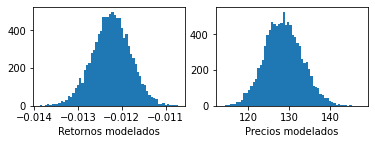

In [58]:
plt.subplot(2,2,1)
plt.hist(St3[:,-1], bins=60, label='Retornos modelados')
plt.xlabel("Retornos modelados")
plt.subplot(2,2,2)
plt.hist(St0[:,-1],bins=60, label='Precio modelados')
plt.xlabel("Precios modelados")
plt.show()

In [59]:
St3[:,-1].mean(), St3[:,-1].std()

(-0.012240825235178861, 0.0004378361721971814)

La gráfica que muestra los retornos simulados parece presentar una distribución normal, con media -0.0122 y desviación 0.00043. Se presentan pérdidas.

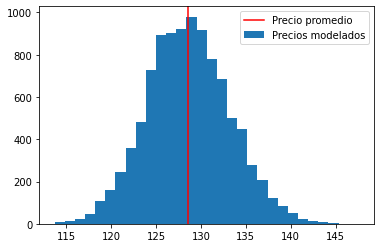

In [ ]:
plt.hist(St0[:,-1], bins=30, label='Precios modelados')
plt.axvline(St0[:,-1].mean(), color='r', label='Precio promedio')
plt.legend();

In [ ]:
St0[:,-1].mean()  

128.5969781589799

In [ ]:
S0 * np.exp(mu * T) 

Adj Close    128.589026
Name: 2021-12-30 00:00:00, dtype: float64

In [57]:
# Prob de que St < 0 
k=0
Stsup = St3[:,-1] > k
Stsup = pd.DataFrame(Stsup)
Stsup.value_counts()

False    10000
dtype: int64

Todos los retornos son inferiores a 0, por lo que la probabilidad de que los retornos sean inferiores a 0 es del 100%

# Punto 2:Con las acciones de: JPM, MCD, META, WMT

In [ ]:
# Precios históricos para los activos seleccionados
activos = ["JPM", "MCD", "WMT","META"]
precios = yf.download(activos,start="2010-01-01",end="2021-12-31")
precios = precios.loc[:,"Adj Close"]
retornos=np.log(precios/precios.shift()).dropna()
mu=retornos.mean()
cov=retornos.cov()
sigma=retornos.std()
n=len(mu)
mu,cov,sigma

[*********************100%***********************]  4 of 4 completed


(JPM     0.000751
 MCD     0.000565
 META    0.000908
 WMT     0.000433
 dtype: float64,            JPM       MCD      META       WMT
 JPM   0.000277  0.000098  0.000111  0.000057
 MCD   0.000098  0.000152  0.000087  0.000048
 META  0.000111  0.000087  0.000526  0.000048
 WMT   0.000057  0.000048  0.000048  0.000150, JPM     0.016645
 MCD     0.012330
 META    0.022940
 WMT     0.012263
 dtype: float64)

In [ ]:
w = cp.Variable(n)
risk = cp.quad_form(w,cov)
objective = cp.Minimize(risk)
constraints = [cp.sum(w)==1, w>=0]
optim = cp.Problem(objective, constraints)
optim.solve()
wpmvg = w.value
round(pd.DataFrame(wpmvg),4)#Valores de los pesos del portfalio PMV  

,0
0,0.0888
1,0.3962
2,0.0561
3,0.4589


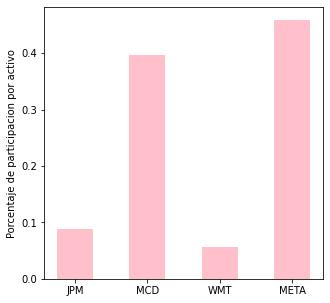

In [ ]:
grafico=plt.figure(figsize=(5,5))
plt.bar(activos,wpmvg,width=0.5, color="pink")
plt.ylabel("Porcentaje de participacion por activo")
plt.show()

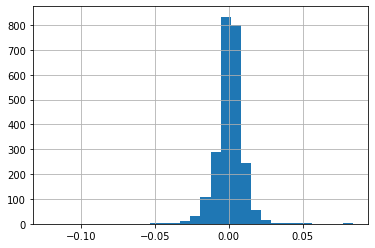

In [ ]:
ret_port=retornos @ wpmvg
ret_port.hist(bins=30); #Grafica retornos del portafolio 

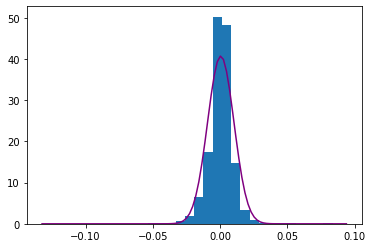

In [ ]:
#Grafica retornos y sigma del portafolio 
rp = ret_port.mean()
sigmap = ret_port.std()
rp,sigmap
plt.hist(ret_port, bins=30, density=True)
xmin,xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
px = norm.pdf(x,rp,sigmap)
plt.plot(x,px,"purple");

#VaR historico

In [ ]:
#VaR histórico 95% de confianza 
VaRH = np.percentile(ret_port,5) 
VaRH

-0.013977074772274977

In [ ]:
#VaR histórico 99% de confianza 
VaRH = np.percentile(ret_port,1) 
VaRH

-0.024284904753452182

Con un nivel de 95% de significancia nos da una perdida maxima del 1,39% del valor del portafolio. Y para un nivel del 99% de significancia la maxima perdida es de 2,42% 

#VaR estandar

In [ ]:
#VaR estandar al 95% de confianza 
alpha = 0.05
VaRp = rp - norm.ppf(1-alpha)*sigmap
VaRp

-0.015576034913841812

In [ ]:
#VaR estandar al 99% de confianza 
alpha = 0.01
VaRp = rp - norm.ppf(1-alpha)*sigmap
VaRp

-0.02225318073642506

Con un nivel de 95% de significancia nos da una perdida maxima del 1,55% del valor del portafolio. Y para un nivel del 99% de significancia la maxima perdida es de 2,22% 

#VaR simulacion

In [ ]:
#VaR de simulacion al 95% de confianza 
zx=1.645 #Valor de la tabla 
Del = rp - zx*sigmap
Del

-0.01557746904801637

In [ ]:
#VaR de simulacion al 99% de confianza 
zx=2.325 #Valor de la tabla 
Del = rp - zx*sigmap
Del

-0.02223997453320382

Con un nivel de 95% de significancia nos da una perdida maxima del 1,55% del valor del portafolio. Y para un nivel del 99% de significancia la maxima perdida es de 2,22% 

Primero, las acciones seleccionadas son JP morgan, MC Donals, Walmart y meta, se construyo el portafolio de Markowits (o de minima varianza PMV) y se le realizaron 6 pruebas de VaR. Recordando que el VaR es la probabilidad de maxima perdida potencial, o perdida esperada para un portafolio. Ahora bien, se hicieron 6 pruebas de VaR. El VaR historico a un nivel de 95% de confianza y a 99% de confianza. El VaR estandar a un nivel de 95% de confianza y a 99% de confianza y finalmente el VaR de simulacion un nivel de 95% de confianza y a 99% de confianza. 
Dandonos unos resultados bastante consistentes. Para todas las pruebas de VaR a un nivel de confianza del 95% nos da una probabilidad de perdida maxima entre el 1,4% y el 1,5%. Mientras que en las pruebas a un nivel de confianza del 99% nos da una perdida maxima entre 2,2% y 2,4%



# Punto 3: Pérdidas de la entidad TuDeuda Ltda

In [ ]:
#Descarga de datos
df= pd.read_excel("/content/DataLoss.xlsx")
df.head()

,Date,Loss
0,2001-01-01,18986
1,2001-02-01,7312
2,2001-03-01,581
3,2001-04-01,4995
4,2001-05-01,10808


In [ ]:
stats = {"media":df["Loss"].mean(),"Desviación":df["Loss"].std(),
         "Curtosis":df["Loss"].kurt(), "Simetria":df["Loss"].skew()}
descripcion = pd.DataFrame(stats, index=["Loss"])
descripcion

,media,Desviación,Curtosis,Simetria
Loss,9983.123016,5591.237909,-1.076109,0.00489


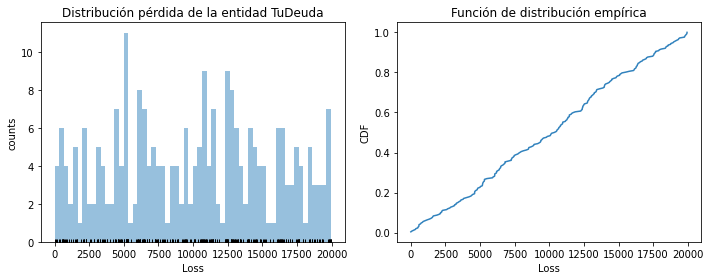

In [ ]:
datos = df.iloc[:,1]
# Gráficos distribución observada (empírica)
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Histograma
axs[0].hist(x=datos, bins=60, color="#3182bd", alpha=0.5)
axs[0].plot(datos, np.full_like(datos, -0.01), '|k', markeredgewidth=1)
axs[0].set_title('Distribución pérdida de la entidad TuDeuda')
axs[0].set_xlabel('Loss')
axs[0].set_ylabel('counts')

# Función de Distribución Acumulada
# ecdf (empirical cumulative distribution function)
ecdf = ECDF(x=datos)
axs[1].plot(ecdf.x, ecdf.y, color="#3182bd")
axs[1].set_title('Función de distribución empírica')
axs[1].set_xlabel('Loss')
axs[1].set_ylabel('CDF')

plt.tight_layout();

Como se muestra, la distribución de las pérdidas de la entidad TuDeuda Ltda tiene una curtosis negativa, esto indica una baja concentración del total de los datos en torno a la media (9983.12). A su vez, tiene una simetría cercana a 0, por lo que es correcto decir que no existe una discriminación de datos hacia la derecha ni hacia la izquierda de la media.  
Estas medidas hacen que se pueda descartar distribuciones como la normal, chi2 entre otras, como posible forma de distribución de las pérdidas de la entidad. En cambio, su nivel de simetría y curtosis puede llevar a pensar que la distribución que mejor se ajusta a los datos es la uniforme.

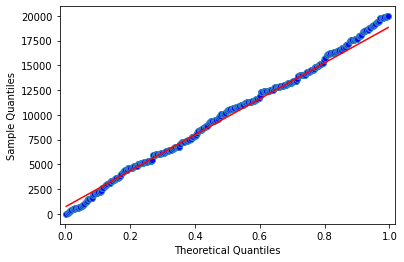

In [ ]:
sm.qqplot(df.iloc[:,1], dist=scipy.stats.distributions.uniform, line="q",color="#3182bd")
py.show()

Se muestra en el QQplot anterior los datos de las pérdidas de la entidad comparadas con los quantiles toéricos de una distribución uniforme, el resultado lleva a pensar que su distribución es similar. A continuación se realiza un ajuste de diferentes distribuciones para observar cual se ajusta más a los datos.

In [ ]:
!pip install --quiet fitter
from fitter import Fitter, get_common_distributions, get_distributions

In [ ]:
#Ajuste de diferentes distribuciones
loss = df.iloc[:,1]
fact1 = Fitter(loss, distributions=get_common_distributions())
fact1.fit()
emp_dist1 = fact1.get_best(method = 'sumsquare_error')
emp_dist1

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 10.82it/s]


{'uniform': {'loc': 4.0, 'scale': 19944.0}}

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
uniform,1.041032e-07,1984.136725,-5433.983819,inf,0.040650,0.783563
powerlaw,1.042813e-07,1986.631183,-5428.023707,inf,0.045614,0.653649
rayleigh,1.240635e-07,2014.631369,-5389.780341,inf,0.083929,0.054174
norm,1.255499e-07,2019.622890,-5386.779128,inf,0.068681,0.177082
gamma,1.255533e-07,2021.622999,-5381.242834,inf,0.068493,0.179411


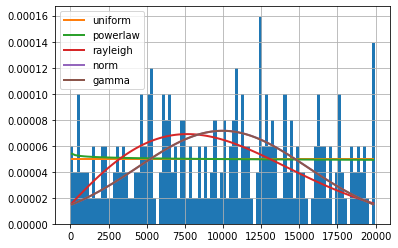

In [ ]:
fact1.summary()

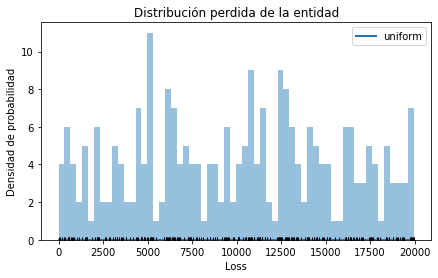

In [ ]:
# Ajuste distribución uniforme
#===============================================================================
# 1) Se define el tipo de distribución
distribucion = stats.uniform

# 2) Con el método fit() se obtienen los parámetros
parametros = distribucion.fit(data=datos)

# 5) Gráfico
x_hat = np.linspace(min(datos), max(datos), num=100)
y_hat = distribucion.pdf(x_hat, *parametros)
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
ax.hist(x=datos, density=False, bins=60, color="#3182bd", alpha=0.5)
ax.plot(datos, np.full_like(datos, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución perdida de la entidad')
ax.set_xlabel('Loss')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

Tras aplicar diferentes distribuciones, se observa como la distribución uniforme se ajusta mejor que el resto a los datos. Para mejor observación, se volvió a hacer el histograma, comparado esta vez solo con la distribución uniforme. A pesar de calificarse como la distribución que mejor se ajusta a los datos dentro de todas las que se compararon, se evidencia como no todos los datos siguen la linea de distribución uniforme. Esto indica que puede haber otro tipo de distribución que se ajuste incluso mejor a los datos.  
~  
Ahora, se ajustan nuevos datos a una distribución binomial, para que con los parámetros N=12 y p=0.2, se pueda hallar la pérdida esperada:

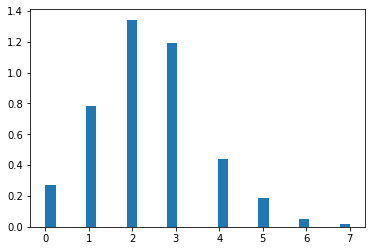

In [ ]:
# Serie con distribución binomial
N = 12
p = 0.2
simulations = len(datos)
ma = np.random.binomial(N, p, simulations)
plt.hist(ma,density=True,bins=30)
plt.show()

# Punto 4: Escoja dos activos que presenten un comportamiento de reversión a la media tipo OU.

[*********************100%***********************]  1 of 1 completed


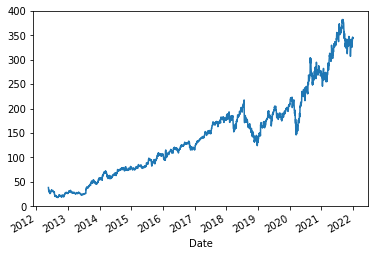

In [ ]:
assets = ["META"] #Meta o Facebook
data = yf.download(assets,start="2000-01-01",end="2021-12-31")
precios = data.loc[:,"Adj Close"]


In [ ]:
retornos = np.log(precios/precios.shift(1)).dropna()
retornos.plot()

In [ ]:
precios.mean()

144.57617509882098

In [ ]:
retornos.mean()

0.0009082921667426518

[*********************100%***********************]  1 of 1 completed


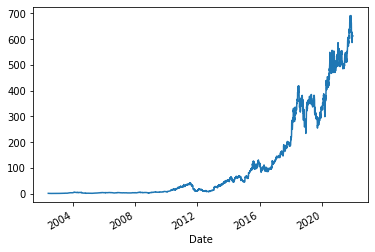

In [ ]:
assets1 = ["NFLX"] #Netflix
data1 = yf.download(assets1,start="2000-01-01",end="2021-12-31")
precios1 = data1.loc[:,"Adj Close"]


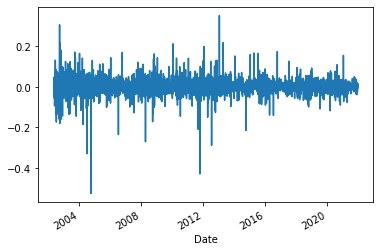

In [ ]:
retornos1 = np.log(precios1/precios1.shift(1)).dropna()
retornos1.plot()

In [ ]:
precios1.mean()

111.51116050577897

In [ ]:
retornos1.mean()

0.0012636827543882649

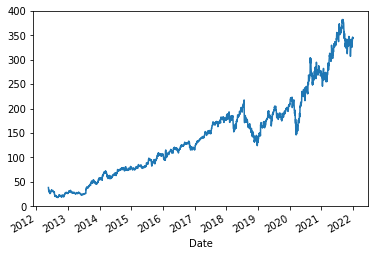

In [ ]:
precios.plot() #Grafica Meta

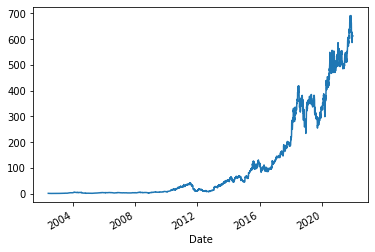

In [ ]:
precios1.plot() #Grafica Netflix

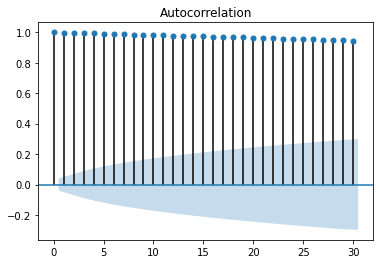

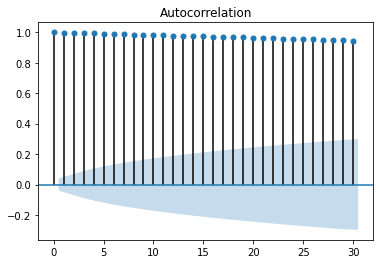

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(precios, lags=30) #META

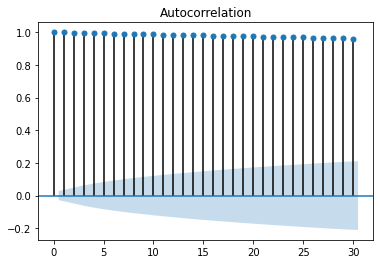

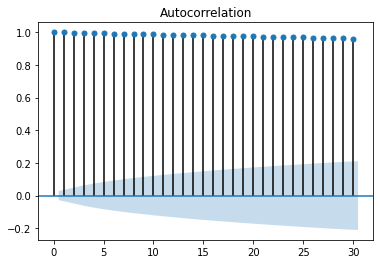

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(precios1, lags=30) #Netlifx

Como no existe una tendencia en ninguna de las dos series no se puede determinar si son estacionarias o no por lo que se debe realizar un test de Dickey Fuller para poder evidenciarlo.

Prueba de Dickey-Fuller para META





In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
pruebadf1 = adfuller(precios)
pruebadf1

(0.17155090036909731,
 0.9706200642643588,
 18,
 2402,
 {'1%': -3.433075354750434,
  '5%': -2.8627440256609367,
  '10%': -2.5674109531399383},
 12689.99237418758)

In [ ]:
print("ADF test: %f" % pruebadf1[0])
print("P-value: %f" % pruebadf1[1])
print("Citical values:")
for key, value in pruebadf1[4].items():
  print("\t%s: %f" %(key,value))

ADF test: 0.171551
P-value: 0.970620
Citical values:
	1%: -3.433075
	5%: -2.862744
	10%: -2.567411


El P-Value de nuestro activo META, indica que se rechaza la hipotesis nula, por lo que podriamos decir que este activo si es Estacionario

Prueba de Dickey-Fuller para Netflix

In [ ]:
pruebadf2 = adfuller(precios1)
pruebadf2

(2.5070283366587995,
 0.9990520818703919,
 30,
 4906,
 {'1%': -3.4316836169639022,
  '5%': -2.862129312003349,
  '10%': -2.5670836919209554},
 29048.29174060856)

In [ ]:
print("ADF test: %f" % pruebadf2[0])
print("P-value: %f" % pruebadf2[1])
print("Citical values:")
for key, value in pruebadf2[4].items():
  print("\t%s: %f" %(key,value))

ADF test: 2.507028
P-value: 0.999052
Citical values:
	1%: -3.431684
	5%: -2.862129
	10%: -2.567084


 Por otro lado, el teste ADF para Netflix tambien muestra un P-Value mayor a la significancia por lo que se rechaza la hipotesis nula, indicando que este activo es estacionario

Construya 100 trayectorias o simulaciones para cada activo con periodicidad mensual y
con duración T=1.

In [ ]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    St = S # {"S":S} 
    return St

In [ ]:
#Estimacion de parametros para META
mu1=retornos.mean()
sigma1=retornos.std()


In [ ]:
datos1=pd.DataFrame(precios)
T1 = 1
mu1 = mu1
sigma1 = sigma1
S01 = datos1.iloc[-1,:]
NS1= 1000
M1 = 12
St1 = PathsGBM(S01,mu1,sigma1,T1,NS1,M1)

Text(0, 0.5, 'S(t)')

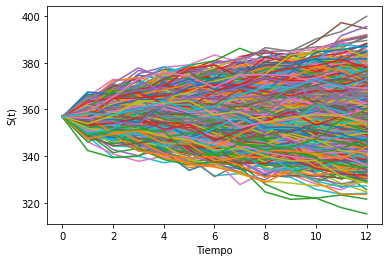

In [ ]:
plt.plot(np.transpose(St1)) 
plt.xlabel("Tiempo")
plt.ylabel("S(t)")

In [ ]:
#Estimacion de parametros para Netflix
mu2=retornos1.mean()
sigma2=retornos1.std()

In [ ]:
datos2=pd.DataFrame(precios1)
T2 = 1
mu2 = mu2
sigma2 = sigma2
S02 = datos2.iloc[-1,:]
NS2= 1000
M2 = 12
St2 = PathsGBM(S02,mu2,sigma2,T2,NS2,M2)

Text(0, 0.5, 'S(t)')

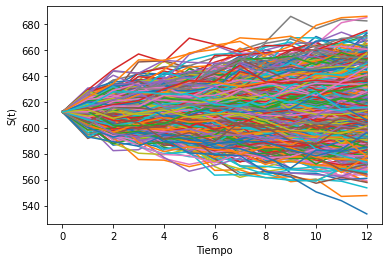

In [ ]:
plt.plot(np.transpose(St2)) 
plt.xlabel("Tiempo")
plt.ylabel("S(t)")

Finalmente con las trayectorias y la estimacion de parametros, podemos observar con mas precision el valor de las trayectorias elegidas